# COMP 5214 Project

## Settings

In [ ]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

import torchvision

import matplotlib.pyplot as plt

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device {device}...')

Using device cuda...


In [ ]:
data_dir = './data'

## Model and Training

In [ ]:
def LeNet():
  return nn.Sequential(
    nn.Conv2d(1, 6, 5, padding = 2), # padding to match the dimensions
    nn.Sigmoid(),
    nn.AvgPool2d(2),

    nn.Conv2d(6, 16, 5),
    nn.Sigmoid(),
    nn.AvgPool2d(2),

    nn.Flatten(),

    nn.Linear(5 * 5 * 16, 120),
    nn.Sigmoid(),
    nn.Linear(120, 84),
    nn.Sigmoid(),
    nn.Linear(84, 10)
  )

In [ ]:
num_epoch = 32
batch_size = 128

In [ ]:
# load the datasets
training_set = torchvision.datasets.MNIST('./data', train= True, download= True, transform= torchvision.transforms.ToTensor())
training_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle = True)
testing_set = torchvision.datasets.MNIST('./data', train= False, download= True, transform= torchvision.transforms.ToTensor())
testing_loader = torch.utils.data.DataLoader(testing_set, batch_size=batch_size, shuffle = True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
model = LeNet().to(device)
Loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [ ]:
# training loop
for i in range(num_epoch):
  epoch_loss = 0.0
  for X, y in training_loader:
    optimizer.zero_grad()
    logits = model(X.to(device))
    loss = Loss(input = logits, target = y.to(device))
    loss.backward()
    epoch_loss += loss.item() * len(y)
    optimizer.step()

  print(f'Epoch {i}, loss {epoch_loss / len(training_set):.3f}')

Epoch 0, loss 1.571
Epoch 1, loss 0.437
Epoch 2, loss 0.258
Epoch 3, loss 0.190
Epoch 4, loss 0.150
Epoch 5, loss 0.125
Epoch 6, loss 0.106
Epoch 7, loss 0.092
Epoch 8, loss 0.081
Epoch 9, loss 0.073
Epoch 10, loss 0.066
Epoch 11, loss 0.059
Epoch 12, loss 0.056
Epoch 13, loss 0.051
Epoch 14, loss 0.047
Epoch 15, loss 0.044
Epoch 16, loss 0.042
Epoch 17, loss 0.038
Epoch 18, loss 0.036
Epoch 19, loss 0.034
Epoch 20, loss 0.033
Epoch 21, loss 0.029
Epoch 22, loss 0.029
Epoch 23, loss 0.027
Epoch 24, loss 0.025
Epoch 25, loss 0.023
Epoch 26, loss 0.023
Epoch 27, loss 0.020
Epoch 28, loss 0.020
Epoch 29, loss 0.018
Epoch 30, loss 0.018
Epoch 31, loss 0.016


In [ ]:
# test the model on the testing set
correct = 0
model.eval()
with torch.no_grad():
  for X, y in testing_loader:
    logits = model(X.to(device))
    _, pred = logits.max(axis = -1)
    correct += (pred == y.to(device)).sum().item()

# report the result
print(f'Accuracy = {correct / len(testing_set):.4f}')

Accuracy = 0.9869


## Smoothing

In [ ]:
from torch.fft import ifft2
num_class, num_sample = 10, 100

def generate_noisy_img(img, num_sample, std):
  N, C, H, W = img.shape 
  fourier_domain_noise = torch.view_as_complex(torch.normal(mean = 0.0, std = std / np.sqrt(2), size = (N, num_sample, C, H, W, 2), device = device))
  pixel_domain_noise = torch.real(ifft2(fourier_domain_noise))
  return img[:, None, ...] + pixel_domain_noise

In [ ]:
correct = 0
sigma = 64.0

model.eval()

with torch.no_grad():
  for X, y in testing_loader:
    samples = generate_noisy_img(X.to(device), num_sample, sigma)
    logits = model(samples.view(-1, *samples.shape[-3:])).view(*samples.shape[:-3], -1)
    pred = logits.argmax(axis = -1)
    frequencies = F.one_hot(pred, num_classes = 10).sum(axis = -2) / num_sample
    
    correct += (frequencies.argmax(axis = -1) == y.to(device)).sum().item()

# report the result
print(f'Accuracy = {correct / len(testing_set):.4f}')

Accuracy = 0.3346


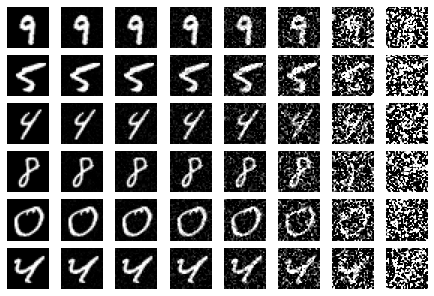

In [ ]:
# display
sigmas = [1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0]
num_samples = 6
fig, axes =plt.subplots(nrows=num_samples, ncols = len(sigmas) + 1, constrained_layout = True)

for i in range(num_samples):
  X, _ = testing_set[np.random.randint(len(testing_set))]
  X = X.numpy().squeeze(0)
  im = axes[i, 0].imshow(X, vmin = 0, vmax = 1, cmap = 'gray')
  for ax, s in zip(axes[i, 1:], sigmas):
    fourier_domain_noise = np.random.normal(loc = 0.0, scale = s / np.sqrt(2), size = (28, 28, 2)).view(complex).squeeze(-1)
    pixel_domain_noise = np.real(np.fft.ifft2(fourier_domain_noise))
    im = ax.imshow(X + pixel_domain_noise, vmin = 0, vmax = 1, cmap = 'gray')

for ax in axes.flatten():
  ax.set_axis_off()